# GPT-2

## Load Data and Tokenize

In [1]:
# Shakespear dataset
data_path = "../../data/input.txt"

with open(data_path, "r", encoding="utf-8") as file:
    text = file.read()

In [2]:
data = text[:1000]
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [4]:
import tiktoken

In [5]:
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(data)
print(tokens[:24])


[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


## Get batches for training

In [6]:
import torch

In [11]:
buf = torch.tensor(tokens[:24 + 1]) # +1 for the next token target

In [12]:
buf

tensor([ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,
         3285,   502,  2740,    13,   198,   198,  3237,    25,   198,  5248,
          461,    11,  2740,    13,   198])

In [14]:
# Reshape to get 4 batches of 6 tokens
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
print(x)
print(y)


tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


## GPT-2 Training Log

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
# parse and visualize the logfile
sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]

# load the log file
with open("../../src/nano_gpt/log/log_0.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))



Min Train Loss: 3.354605
Min Validation Loss: 3.5837


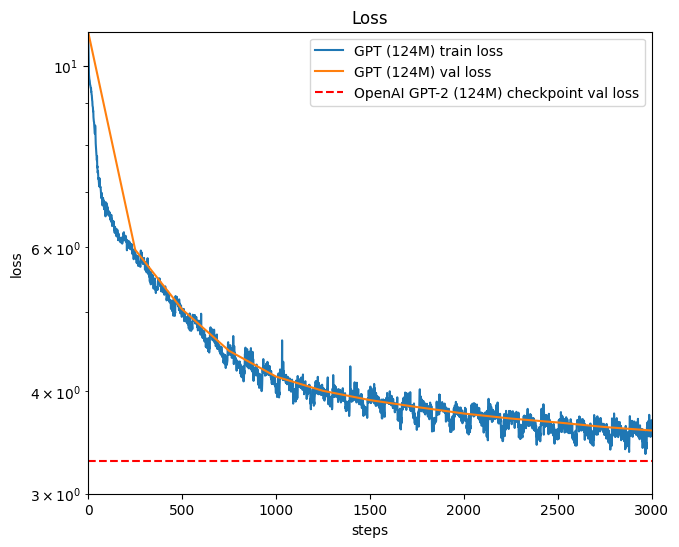

In [14]:
%matplotlib inline

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'GPT ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'GPT ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=11.0, bottom=3.0)
plt.xlim(left=0, right=3000)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))